## Importations

In [1]:
import pandas as pd
from pmdarima import auto_arima
from pmdarima.arima import ARIMA
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

SPLIT_DATASET = False # Use this if you want to perform tests on parts of the time series
DATASET_SPLIT_RATIO = 0.85 # If SPLIT_DATASET, is set to True, defines how much of the data should be used for training
FORECAST_LENGTH = 120 # Number of forecast samples to generate if SPLIT_DATASET is set to False


/tmp/ipykernel_11828/644231155.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Chargement des données

In [2]:
data = pd.read_csv("./data/GlobalTemperatures.csv")
# Getting rid of empty values
temp = data["LandAndOceanAverageTemperature"].interpolate()[1300:]
dates = pd.to_datetime(data["dt"])[1300:]

if SPLIT_DATASET:
    TRAINING_SAMPLES_COUNT = int(len(dates) * DATASET_SPLIT_RATIO)
    train, test = train_test_split(temp, train_size=TRAINING_SAMPLES_COUNT)
    train_dates, future_dates = train_test_split(dates, train_size=TRAINING_SAMPLES_COUNT)
else:
    train = temp
    train_dates = dates

## Recherche des meilleurs paramètres et entraînement

Paramètres du meilleur modèle :
Best model:  ARIMA(1,1,1)(2,0,2)[12] intercept

In [3]:
#model = auto_arima(train, seasonal=True, m=12, trace=True)
#print(str(model.summary()))
model = ARIMA(order=(1, 1, 1), seasonal_order=(2, 0, 2, 12))
model.fit(train)


ARIMA(order=(1, 1, 1), seasonal_order=(2, 0, 2, 12))

## Prédiction

In [4]:
if SPLIT_DATASET:
    forecasts = model.predict(len(test))  # predict N steps into the future
else:
    forecasts = model.predict(FORECAST_LENGTH)  # predict 10 years into the future

## Visualisation

/tmp/ipykernel_11828/3656806175.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start_date, periods=FORECAST_LENGTH, freq="M").to_series()


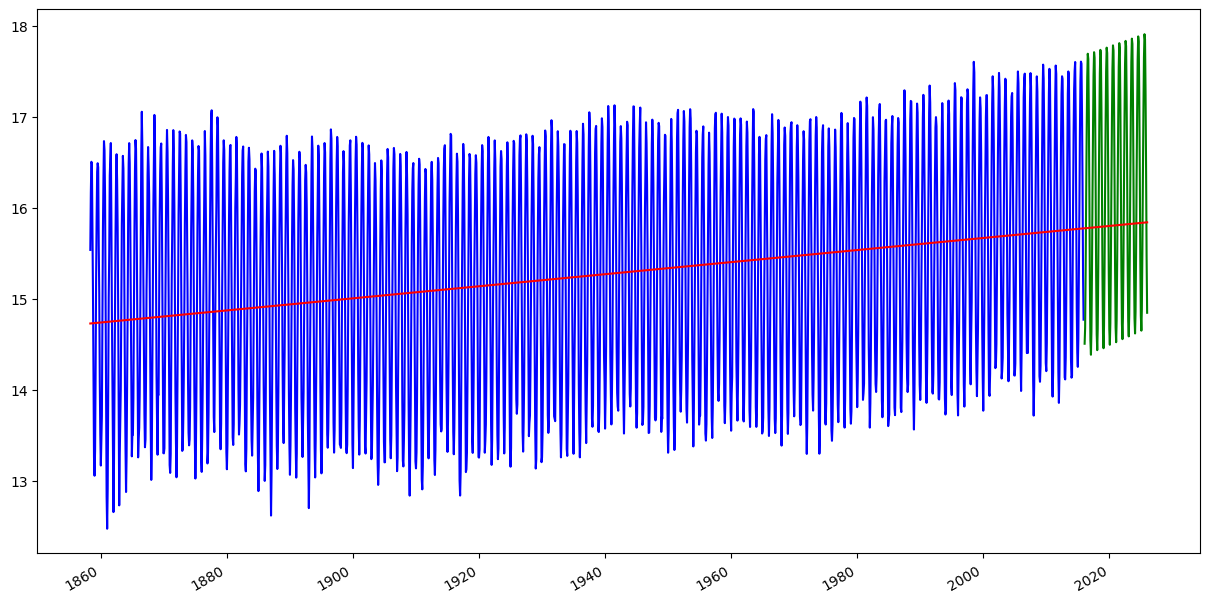

In [6]:
# Visualize the forecasts (blue=train, green=forecasts)
plt.figure(figsize=(15,8))


if SPLIT_DATASET:
    x = np.arange(len(temp))
    trend = np.polyfit(x, pd.concat([train, forecasts]), 1)

else:
    # Generating extra dates for the forecast
    start_date = dates.iloc[-1] + pd.DateOffset(months=1)
    future_dates = pd.date_range(start_date, periods=FORECAST_LENGTH, freq="M").to_series()
    all_dates = pd.concat([dates, future_dates])
    x = np.arange(len(all_dates))
    trend = np.polyfit(x, pd.concat([train, forecasts]), 2)




trendpoly = np.poly1d(trend)
plt.plot(train_dates, train, c='blue')
plt.plot(future_dates, forecasts, c='green')
plt.plot(all_dates, trendpoly(x), c="red")
plt.gcf().autofmt_xdate()
plt.show()

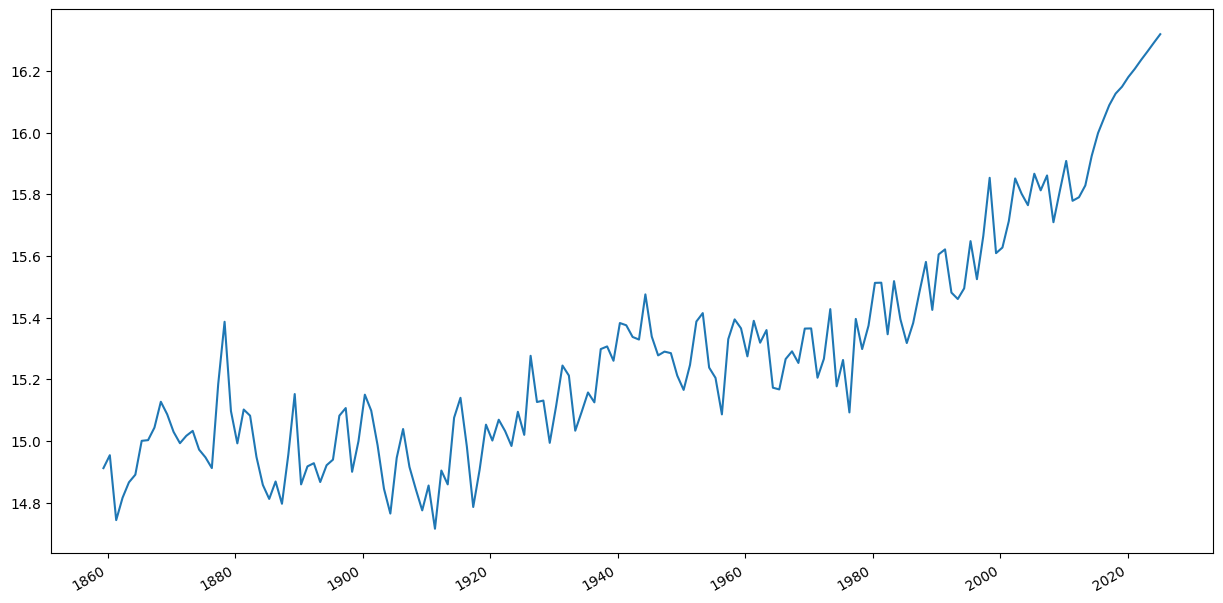

In [28]:
# Visualisation en faisant des moyennes de température annuelles, pour plus de visibilité
plt.figure(figsize=(15,8))

train.index = train_dates
yearly_train = train.rolling(window=12, step=12, center=True).mean().dropna()

forecasts.index = future_dates
yearly_forecasts = forecasts.rolling(window=12, step=12, center=True).mean().dropna()

all_data = pd.concat([yearly_train, yearly_forecasts])
x = np.arange(len(all_data))

plt.plot(all_data)
plt.gcf().autofmt_xdate()



On pourra aussi utiliser ce modèle pour réaliser 